## AQ1601 Acrobat Basic Data

In [26]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

### connecting to erddap and retrieving and basic information

In [27]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='acrobat'))

In [28]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 2 tabledap, 0 griddap, and 0 wms endpoints.'

In [29]:
datasets = df['Dataset ID'].values
print(datasets)

['erddap_AQ1601_Acrobat' 'erddap_OS1701L1_Acrobat']


In [30]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in datasets]
print(variables)

[['time', 'longitude', 'Salinity', 'latitude', 'Conductivity', 'depth'], ['oxygen_airsaturation', 'time', 'longitude', 'Salinity', 'latitude', 'Conductivity', 'depth']]


### retrieving erddap and plotting data

In [31]:
constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = [
 'Temperature',
 'Conductivity',
 'Salinity', 
 'depth',
 'latitude',
 'longitude',
 'time'
]

variable_dic={}

for index,row in df.iterrows():
    info_url = e.get_info_url(dataset_id=row['Dataset ID'], response='csv')
    info = pd.read_csv(info_url)

    #print(info.head())
    print('Variables in {}:'.format(row['Dataset ID']))
    print(','.join(info.loc[info['Row Type'] == 'variable', 'Variable Name']))

    variable_dic.update({row['Dataset ID']:list(info.loc[info['Row Type'] == 'variable', 'Variable Name'])})
    

Variables in erddap_AQ1601_Acrobat:
trajectory_id,record_number,Temperature,depth,eng_460nm_counts,Conductivity,longitude,Salinity,eng_700nm_counts,time,latitude,eng_695nm_counts,SigmaT,speed_over_ground
Variables in erddap_OS1701L1_Acrobat:
trajectoryid,record_number,Temperature_Optode,Temperature,depth,eng_460nm_counts,Conductivity,longitude,Salinity,eng_700nm_counts,oxygen_concentration,time,latitude,eng_695nm_counts,SigmaT,oxygen_airsaturation,speed_over_ground


In [32]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in ['erddap_AQ1601_Acrobat']:
        print(row['Dataset ID'])
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            e.variables=variables
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})
    

erddap_AQ1601_Acrobat


### Plot using GMT-Python

In [33]:
import gmt

In [44]:
fig1 = gmt.Figure()

fig1.coast(region=[-175, -155, 69, 72], projection='B-165/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [45]:
#color by sst
for cruise, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.Temperature.loc[(df.Temperature > 15) | (df.Temperature <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.Temperature, cmap='thermal', style='c0.05c')


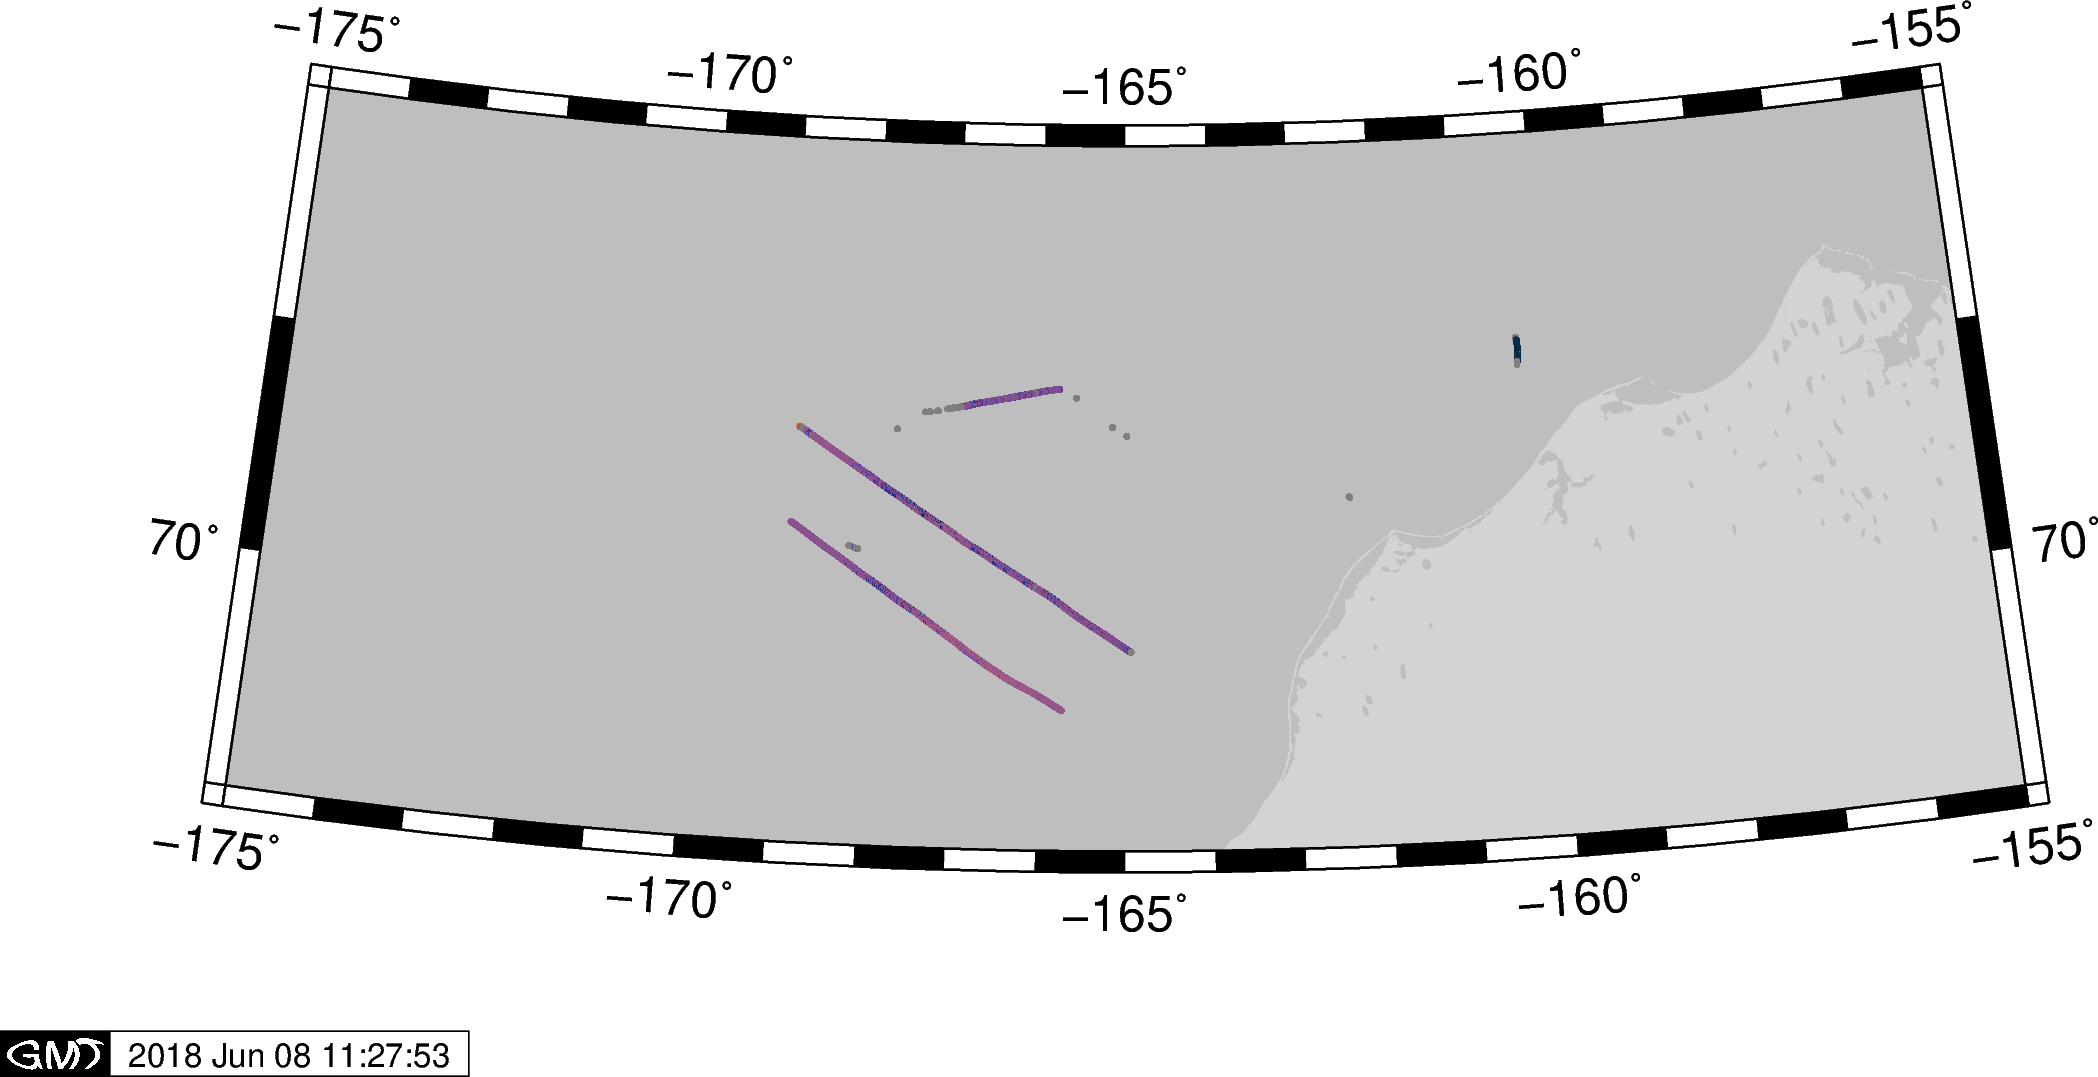

In [46]:
fig1.show()

In [37]:
df

,Temperature,Conductivity,Salinity,depth,latitude,longitude
time,,,,,,
2016-09-12 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12 03:00:01,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12 03:00:02,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12 03:00:03,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12 03:00:04,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12 03:00:05,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12 03:00:06,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12 03:00:07,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12 03:00:08,NaN,NaN,NaN,NaN,NaN,NaN
